# Try out the GSMT simulator

In [10]:
# try it out
import numpy as np
import matplotlib.pyplot as plt
# windows only
# import zosapi
# zos = zosapi.App()
import gsmt
from gsmt import (
    sim_params,
    filters,
    tmt_conf,
    elt_conf,
    gmt_conf,
    sim_gsmt_jones_pupil
)
from hcipy import *
from importlib import reload

# I think the surfaces are wrong

In [27]:
sim_params['wavelength'] = filters['I'] * 1e-6
sim_params['order'] = 6
sim_params['npix_pupil'] = 1024
sim_params['segment variation'] = False
sim_params['poke.Rayfront'] = 'rayfronts/ELT.msgpack'

wfout = sim_gsmt_jones_pupil(sim_params, elt_conf)

sim_params['segment variation'] = True

wfout_aberrated = sim_gsmt_jones_pupil(sim_params, elt_conf)

17017
17017


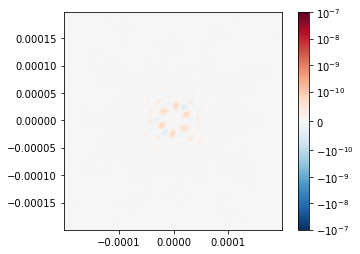

In [28]:
from matplotlib.colors import SymLogNorm
normdef = SymLogNorm(vmin=-1e-7,vmax=1e-7,linthresh=1e-10)
# imshow_field(np.log10(wfout.power),vmin=-12,vmax=0)
# plt.colorbar()
imshow_field((wfout.power - wfout_aberrated.power), cmap='RdBu_r', norm=normdef)
plt.colorbar()

In [29]:
# try a whole data cyoob
residual_cube = np.zeros([25,*wfout.power.shaped.shape])
print(residual_cube.shape)

(25, 150, 150)


In [30]:
def str_to_int(string):
    a = string.encode()
    a = int.from_bytes(a,'little')
    return a

str_to_int('mauka')

418414682477

In [31]:
randseeds = ['ohana','mahalo','aloha','makai','mauka',
             'uamau','keeao','kaaina','ika','pono',
             'mauna','keiki','kokua','lanai','kauai',
             'akamai','olelo','iiwi','hee','kupuna',
             'hoku','honu ','hula','kaolo','kane']

for i,rand in enumerate(randseeds):
    reload(gsmt)
    from gsmt import sim_params
    sim_params['wavelength'] = filters['I'] * 1e-6
    sim_params['order'] = 6
    sim_params['npix_pupil'] = 1024
    sim_params['segment variation'] = True
    sim_params['poke.Rayfront'] = 'rayfronts/ELT.msgpack'
    sim_params['random seed'] = int(str_to_int(rand) / 1e5)

    residual_cube[i] = sim_gsmt_jones_pupil(sim_params, elt_conf).power.shaped

4184637
1225112813
4183639
4526059
4184146
5041457
4783754
1071268422
63
18695
4184650
4527736
4185818
4526061
4526066
1158671678
4785599
17694
66
1071270446
19699
1394091
16344
4785606
17017


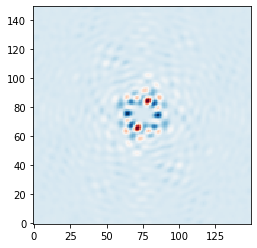

In [32]:
plt.imshow(wfout.power.shaped - residual_cube[0],cmap='RdBu_r')

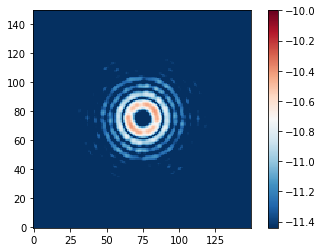

In [34]:
std_trials = np.std(residual_cube,axis=0)
mean_trials = np.mean(residual_cube,axis=0)
plt.imshow(np.log10(std_trials),cmap='RdBu_r',vmin=-10)
plt.colorbar()

In [35]:
np.save('25trials_order6_ELT_Iband_primaryvar.npy',residual_cube)

In [36]:
def reg_radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

# load up the profiles
tmt_cube_o2 = np.load('25trials_order2_TMT_Iband_primaryvar.npy')
elt_cube_o2 = np.load('25trials_order2_ELT_Iband_primaryvar.npy')
gmt_cube_o2 = np.load('25trials_order2_GMT_Iband_primaryvar.npy')

tmt_cube_o4 = np.load('25trials_order4_TMT_Iband_primaryvar.npy')
elt_cube_o4 = np.load('25trials_order4_ELT_Iband_primaryvar.npy')
gmt_cube_o4 = np.load('25trials_order4_GMT_Iband_primaryvar.npy')

tmt_cube_o6 = np.load('25trials_order6_TMT_Iband_primaryvar.npy')
elt_cube_o6 = np.load('25trials_order6_ELT_Iband_primaryvar.npy')
gmt_cube_o6 = np.load('25trials_order6_GMT_Iband_primaryvar.npy')

rad_tmt_2 = reg_radial_profile(np.std(tmt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_elt_2 = reg_radial_profile(np.std(elt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_gmt_2 = reg_radial_profile(np.std(gmt_cube_o2,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

rad_tmt_4 = reg_radial_profile(np.std(tmt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_elt_4 = reg_radial_profile(np.std(elt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_gmt_4 = reg_radial_profile(np.std(gmt_cube_o4,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

rad_tmt_6 = reg_radial_profile(np.std(tmt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_elt_6 = reg_radial_profile(np.std(elt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])
rad_gmt_6 = reg_radial_profile(np.std(gmt_cube_o6,axis=0),[mean_trials.shape[0]/2,mean_trials.shape[0]/2])

<ipython-input-36-2912d89003a8>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r = r.astype(np.int)


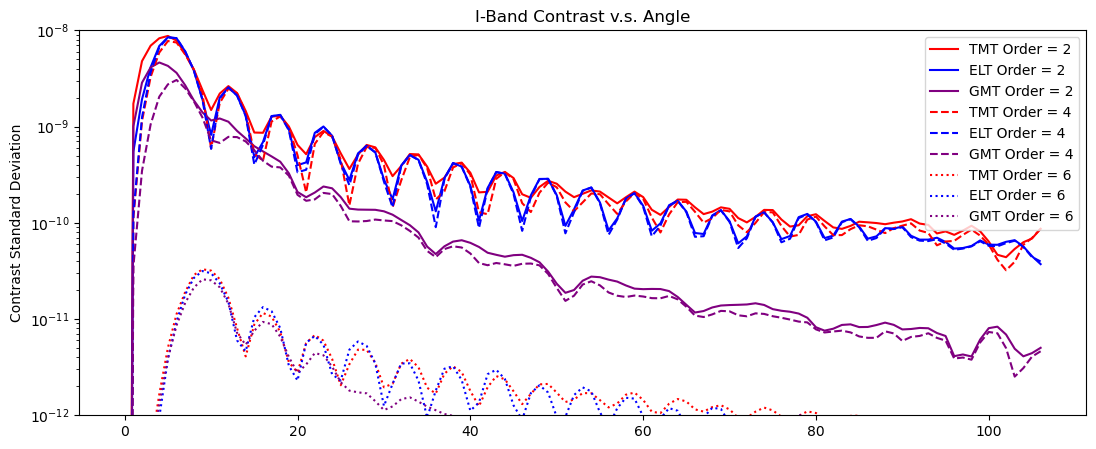

In [64]:
# plt.plot(rad + rad_std)
plt.figure(figsize=[13,5])
plt.title('I-Band Contrast v.s. Angle')
# plt.subplot(131)
plt.plot(rad_tmt_2,label='TMT Order = 2',color='red',linestyle='solid')
plt.plot(rad_elt_2,label='ELT Order = 2',color='blue',linestyle='solid')
plt.plot(rad_gmt_2,label='GMT Order = 2',color='purple',linestyle='solid')
# plt.legend()
# plt.ylim(1e-10,1e-8)
# plt.yscale('log')
# plt.subplot(132)
plt.plot(rad_tmt_4,label='TMT Order = 4',color='red',linestyle='dashed')
plt.plot(rad_elt_4,label='ELT Order = 4',color='blue',linestyle='dashed')
plt.plot(rad_gmt_4,label='GMT Order = 4',color='purple',linestyle='dashed')
# plt.legend()
# plt.ylim(1e-10,1e-8)
# plt.yscale('log')
# plt.subplot(133)
plt.plot(rad_tmt_6,label='TMT Order = 6',color='red',linestyle='dotted')
plt.plot(rad_elt_6,label='ELT Order = 6',color='blue',linestyle='dotted')
plt.plot(rad_gmt_6,label='GMT Order = 6',color='purple',linestyle='dotted')
plt.yscale('log')
plt.legend()
plt.ylim(1e-12,1e-8)
plt.ylabel('Contrast Standard Deviation')
plt.show()